#### Build the random forest model after normalizing the variable to house pricing from boston data set.

In [54]:
import sklearn.datasets as datasets

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

# We want to make sure all numbers display in a consistent manner
pd.options.display.float_format = '{:.5f}'.format

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Load dataset
data = datasets.load_boston()
# Extract feature names, predictors and targets from sklearn dictionary
names = data.feature_names
predictors = data.data
targets = data.target
# Concatenate predictors and targets for easier processing later on. Let's also name the columns.
df = pd.concat([pd.DataFrame(predictors, columns=names), pd.DataFrame(targets, columns=['MEDV'])], axis=1)

In [39]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.00000,2.31000,0.00000,0.53800,6.57500,65.20000,4.09000,1.00000,296.00000,15.30000,396.90000,4.98000,24.00000
1,0.02731,0.00000,7.07000,0.00000,0.46900,6.42100,78.90000,4.96710,2.00000,242.00000,17.80000,396.90000,9.14000,21.60000
2,0.02729,0.00000,7.07000,0.00000,0.46900,7.18500,61.10000,4.96710,2.00000,242.00000,17.80000,392.83000,4.03000,34.70000
3,0.03237,0.00000,2.18000,0.00000,0.45800,6.99800,45.80000,6.06220,3.00000,222.00000,18.70000,394.63000,2.94000,33.40000
4,0.06905,0.00000,2.18000,0.00000,0.45800,7.14700,54.20000,6.06220,3.00000,222.00000,18.70000,396.90000,5.33000,36.20000


In [40]:
df.dtypes.value_counts()

float64    14
dtype: int64

In [41]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000,506.00000
mean,3.59376,11.36364,11.13678,0.06917,0.55470,6.28463,68.57490,3.79504,9.54941,408.23715,18.45553,356.67403,12.65306,22.53281
std,8.59678,23.32245,6.86035,0.25399,0.11588,0.70262,28.14886,2.10571,8.70726,168.53712,2.16495,91.29486,7.14106,9.19710
min,0.00632,0.00000,0.46000,0.00000,0.38500,3.56100,2.90000,1.12960,1.00000,187.00000,12.60000,0.32000,1.73000,5.00000
25%,0.08204,0.00000,5.19000,0.00000,0.44900,5.88550,45.02500,2.10018,4.00000,279.00000,17.40000,375.37750,6.95000,17.02500
50%,0.25651,0.00000,9.69000,0.00000,0.53800,6.20850,77.50000,3.20745,5.00000,330.00000,19.05000,391.44000,11.36000,21.20000
75%,3.64742,12.50000,18.10000,0.00000,0.62400,6.62350,94.07500,5.18843,24.00000,666.00000,20.20000,396.22500,16.95500,25.00000
max,88.97620,100.00000,27.74000,1.00000,0.87100,8.78000,100.00000,12.12650,24.00000,711.00000,22.00000,396.90000,37.97000,50.00000


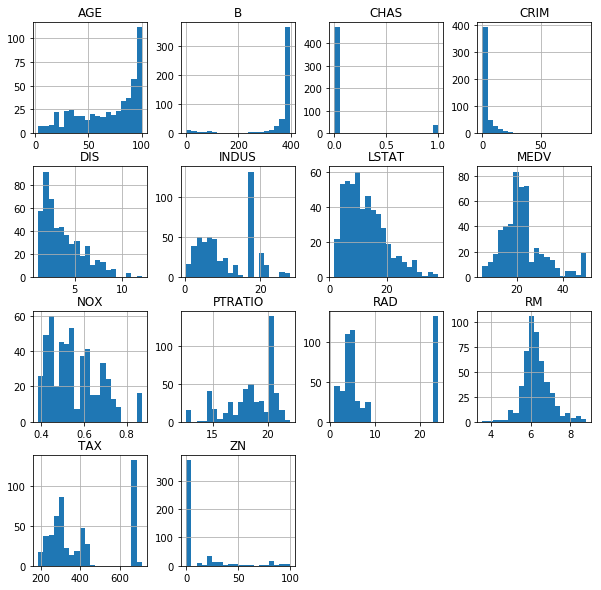

In [42]:
df.hist(figsize=(10, 10), bins=20)
plt.show()

In [43]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

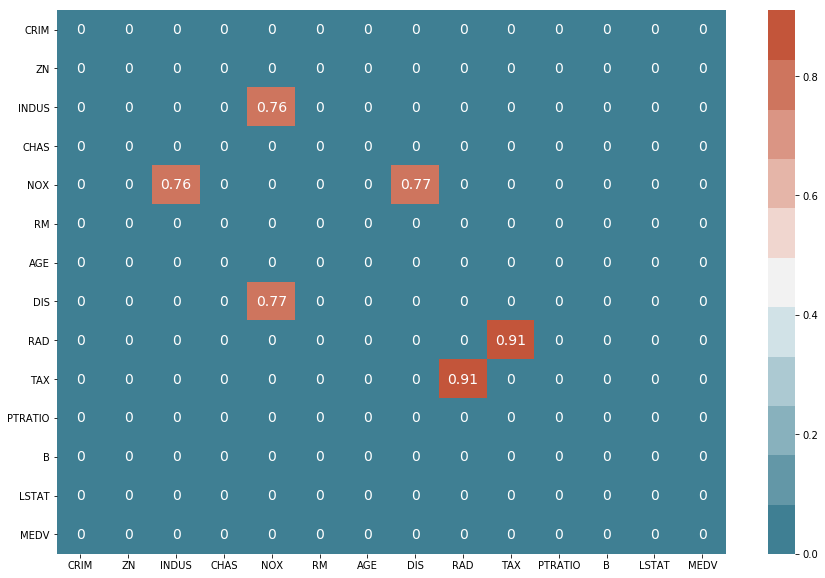

In [44]:
df_corr = df.corr().abs()
filter = (df_corr == 1) | (df_corr < 0.75)
df_corr[filter] = 0
df_corr

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, annot_kws={'size': 14},
            cmap=sns.diverging_palette(220, 20, n=11))

In [45]:
#Dimensionality reduction
cols_corr_manual = ['NOX', 'RAD']
df = df.drop(columns=cols_corr_manual)
df.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.00000,2.31000,0.00000,6.57500,65.20000,4.09000,296.00000,15.30000,396.90000,4.98000,24.00000
1,0.02731,0.00000,7.07000,0.00000,6.42100,78.90000,4.96710,242.00000,17.80000,396.90000,9.14000,21.60000
2,0.02729,0.00000,7.07000,0.00000,7.18500,61.10000,4.96710,242.00000,17.80000,392.83000,4.03000,34.70000
3,0.03237,0.00000,2.18000,0.00000,6.99800,45.80000,6.06220,222.00000,18.70000,394.63000,2.94000,33.40000
4,0.06905,0.00000,2.18000,0.00000,7.14700,54.20000,6.06220,222.00000,18.70000,396.90000,5.33000,36.20000


Splitting train and test dataset

In [46]:
# Train-set predictors/targets
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [49]:
x_training_set, x_test_set, y_training_set, y_test_set = train_test_split(X,y,test_size=0.10, 
                                                                          random_state=42,
                                                                          shuffle=True)

In [50]:
#Training/model fitting:
n_estimators=100
# Fit regression model
# Estimate the score on the entire dataset, with no missing values
model = RandomForestRegressor(random_state=0, n_estimators=n_estimators)
model.fit(x_training_set, y_training_set)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
#Model parameters study :
#The coefficient R^2 is defined as (1 – u/v), where u is the residual sum of squares ((y_true – y_pred) ** 2).sum() and v is the total sum of squares ((y_true – y_true.mean()) ** 2).sum().
from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(x_training_set,y_training_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print("coefficient of determination R^2 of the prediction.:",model_score)
y_predicted = model.predict(x_test_set)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test_set, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test_set, y_predicted))

coefficient of determination R^2 of the prediction.: 0.9804086304299443
Mean squared error: 10.36
Test Variance score: 0.83


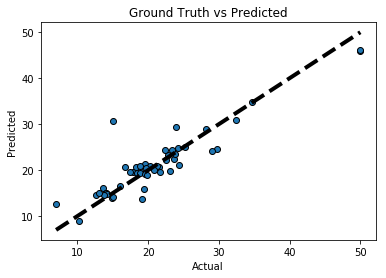

In [52]:
#Accuracy report with test data :
# So let's run the model against the test data
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()

ax.scatter(y_test_set, y_predicted, edgecolors=(0, 0, 0))

ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'k--', lw=4)

ax.set_xlabel('Actual')

ax.set_ylabel('Predicted')

ax.set_title("Ground Truth vs Predicted")

plt.show()